# **Test LSTM and Conv with   xgb_features_selector**

**RELEASE**

In [ ]:
REL = '_R005'

## **Importing libraries and connecting disk, global ads**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Collecting own modules

In [ ]:
import sys
sys.path.append('/gdrive/My Drive/Release/')
import Modules.global_f as mgf
import Modules.xgb_features_selector as xgbfs

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


#Функции

In [ ]:
# Нормирование
def norm_df(df,  shift=1, list_rename=[], cols=[], no_cols=[]):
  df_ = df.copy()
  if cols == []:
    cols = df_.columns
  else: shift = 0
  for k in cols[shift:]:
    if k not in no_cols:
      min_ = df_[k].min()
      max_ = df_[k].max()
      if k in list_rename:
          df_['n_' + k] = df_[k].apply(lambda x: (x-min_)/(max_-min_))
      else:
          df_[k] = df_[k].apply(lambda x: (x-min_)/(max_-min_))
  return df_

In [ ]:
#  Z преобразование
def z_df(df,  shift=1, list_rename=[], cols=[], no_cols=[]):
  df_ = df.copy()
  if cols == []:
    cols = df_.columns
  else: shift = 0
  for k in cols[shift:]:
    if k not in no_cols:
      _mean = df_[k].mean()
      _std = df_[k].std()
      if k in list_rename:
          df_['z_' + k] = df_[k].apply(lambda x: (x -_mean)/_std)
      else:
          df_[k] = df_[k].apply(lambda x: (x -_mean)/_std)
  return df_

In [ ]:
def shift_from_end(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:-n] = xs[n:]
        e[-n:] = xs[-1:]
    return e

In [ ]:
def supplement(xs, n, set_adds = np.nan): # Дополняет  данные значениями set_adds с начала или с конца (+ n или - n )  
    xs = xs.flatten()
    e = np.empty(abs(n))
    e[:abs(n)] = set_adds
    if n > 0:
      e = np.append(e, xs, axis = 0)
    if n < 0:
      e = np.append(xs, e, axis = 0)
    return e

In [ ]:
# Функция добавляет столбцы с ifft  в   датасет в соответствии с фильтрами list_comp_fft, возвращает датасет
def ifft_add_columns(df_, key_, list_comp_fft, n_adds =1):
  _df_ = df_.copy()
  _df_.reset_index()
  arr_big = np.array(_df_[key_]).flatten()
  arr_big = supplement(arr_big,n_adds,arr_big[0])
  arr_big = supplement(arr_big,-n_adds,arr_big[0])
  #print(arr_big.shape)
  #close_fft = np.fft.fft(np.asarray(_df_[key_].tolist()))
  close_fft = np.fft.fft(arr_big)
  fft_df = pd.DataFrame({'fft':close_fft})
  fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
  fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
  fft_list = np.asarray(fft_df['fft'].tolist())
  #print(fft_list.shape)
  for num_ in list_comp_fft:  # числа убирают из центра часточного распределения num_ компонент fft
    fft_list_filtered= np.copy(fft_list)
    fft_list_filtered[num_:-num_] = 0
    ifft_  = np.fft.ifft(fft_list_filtered)
    ifft_df = pd.DataFrame({'ifft':ifft_})
    ifft_df[key_ + '_'+ str(num_)+ '_ifft'] = ifft_df['ifft'].apply(lambda x: np.abs(x))
    ifft_df = ifft_df.drop(columns=['ifft'])
    ifft_df = ifft_df[n_adds:-n_adds].reset_index(drop = True)
    #print(ifft_df.shape)
    _df_ = pd.concat([_df_, ifft_df], axis=1)
    print(_df_.shape)
  return _df_
  

# Реализация

In [ ]:
DATA_PATH = '/gdrive/My Drive/Data/' 
W_PATH = '/gdrive/My Drive/Drafts/TEST_LSTM_Conv_FTSE/'

KEY = 'FTSE 100 Historical Data_Price'#'NYSE Composite Historical Data_Price' #GS_Price'#'USD_RUB Historical Data_Price'#
GS_KEY = 'GS_Price'

In [ ]:
import pandas as pd
#data = pd.read_csv(DATA_PATH + 'data_cleaner_!!clear!!_R001.csv', engine='python')  #, usecols=[1,2,3,4,5,6,7,8,9]
pd.set_option('display.max_columns', None)
df = pd.read_csv(DATA_PATH + 'df_all_scores.csv', parse_dates=[0])
df

,Date,GS_Price,GS_Open,GS_High,GS_Low,GS_Vol.,GS_Change %,GS_diffCO,GS_diffHL,FTSE 100 Historical Data_Price,FTSE 100 Historical Data_Open,FTSE 100 Historical Data_High,FTSE 100 Historical Data_Low,FTSE 100 Historical Data_Vol.,FTSE 100 Historical Data_Change %,FTSE 100 Historical Data_diffCO,FTSE 100 Historical Data_diffHL,Dow Jones Industrial Average Historical Data_Price,Dow Jones Industrial Average Historical Data_Open,Dow Jones Industrial Average Historical Data_High,Dow Jones Industrial Average Historical Data_Low,Dow Jones Industrial Average Historical Data_Vol.,Dow Jones Industrial Average Historical Data_Change %,Dow Jones Industrial Average Historical Data_diffCO,Dow Jones Industrial Average Historical Data_diffHL,S&P 500 Historical Data_Price,S&P 500 Historical Data_Open,S&P 500 Historical Data_High,S&P 500 Historical Data_Low,S&P 500 Historical Data_Change %,S&P 500 Historical Data_diffCO,S&P 500 Historical Data_diffHL,DAX Historical Data_Price,DAX Historical Data_Open,DAX Historical Data_High,DAX Historical Data_Low,DAX Historical Data_Vol.,DAX Historical Data_Change %,DAX Historical Data_diffCO,DAX Historical Data_diffHL,CAC 40 Historical Data_Price,CAC 40 Historical Data_Open,CAC 40 Historical Data_High,CAC 40 Historical Data_Low,CAC 40 Historical Data_Vol.,CAC 40 Historical Data_Change %,CAC 40 Historical Data_diffCO,CAC 40 Historical Data_diffHL,Nikkei 225 Historical Data_Price,Nikkei 225 Historical Data_Open,Nikkei 225 Historical Data_High,Nikkei 225 Historical Data_Low,Nikkei 225 Historical Data_Vol.,Nikkei 225 Historical Data_Change %,Nikkei 225 Historical Data_diffCO,Nikkei 225 Historical Data_diffHL,Shanghai Composite Historical Data_Price,Shanghai Composite Historical Data_Open,Shanghai Composite Historical Data_High,Shanghai Composite Historical Data_Low,Shanghai Composite Historical Data_Vol.,Shanghai Composite Historical Data_Change %,Shanghai Composite Historical Data_diffCO,Shanghai Composite Historical Data_diffHL,Hang Seng Historical Data_Price,Hang Seng Historical Data_Open,Hang Seng Historical Data_High,Hang Seng Historical Data_Low,Hang Seng Historical Data_Vol.,Hang Seng Historical Data_Change %,Hang Seng Historical Data_diffCO,Hang Seng Historical Data_diffHL,KOSPI Historical Data_Price,KOSPI Historical Data_Open,KOSPI Historical Data_High,KOSPI Historical Data_Low,KOSPI Historical Data_Vol.,KOSPI Historical Data_Change %,KOSPI Historical Data_diffCO,KOSPI Historical Data_diffHL,BSE Sensex 30 Historical Data_Price,BSE Sensex 30 Historical Data_Open,BSE Sensex 30 Historical Data_High,BSE Sensex 30 Historical Data_Low,BSE Sensex 30 Historical Data_Vol.,BSE Sensex 30 Historical Data_Change %,BSE Sensex 30 Historical Data_diffCO,BSE Sensex 30 Historical Data_diffHL,Bovespa Historical Data_Price,Bovespa Historical Data_Open,Bovespa Historical Data_High,Bovespa Historical Data_Low,Bovespa Historical Data_Vol.,Bovespa Historical Data_Change %,Bovespa Historical Data_diffCO,Bovespa Historical Data_diffHL,S&P Merval Historical Data_Price,S&P Merval Historical Data_Open,S&P Merval Historical Data_High,S&P Merval Historical Data_Low,S&P Merval Historical Data_Change %,S&P Merval Historical Data_diffCO,S&P Merval Historical Data_diffHL,CBOE Volatility Index Historical Data_Price,CBOE Volatility Index Historical Data_Open,CBOE Volatility Index Historical Data_High,CBOE Volatility Index Historical Data_Low,CBOE Volatility Index Historical Data_Change %,CBOE Volatility Index Historical Data_diffCO,CBOE Volatility Index Historical Data_diffHL,MOEX Russia Historical Data_Price,MOEX Russia Historical Data_Open,MOEX Russia Historical Data_High,MOEX Russia Historical Data_Low,MOEX Russia Historical Data_Change %,MOEX Russia Historical Data_diffCO,MOEX Russia Historical Data_diffHL,Bitcoin Historical Data_Price,Bitcoin Historical Data_Open,Bitcoin Historical Data_High,Bitcoin Historical Data_Low,Bitcoin Historical Data_Vol.,Bitcoin Historical Data_Change %,Bitcoin Historical Data_diffCO,Bitcoin Historical Data_di

In [ ]:
df.info(max_cols=600)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 536 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   Date                                                       2516 non-null   datetime64[ns]
 1   GS_Price                                                   2516 non-null   float64       
 2   GS_Open                                                    2516 non-null   float64       
 3   GS_High                                                    2516 non-null   float64       
 4   GS_Low                                                     2516 non-null   float64       
 5   GS_Vol.                                                    2516 non-null   float64       
 6   GS_Change %                                                2516 non-null   float64       
 7   GS_diffCO                       

In [ ]:
cols_to_work =['Date', KEY, 'Bitcoin Historical Data_Price', 'USD_JPY Historical Data_Price', 'GBP_USD Historical Data_Price',
               'Brent Oil Futures Historical Data_Price', 'EUR_USD Historical Data_Price',   'Dow Jones Basic Materials Historical Data_Price', 
               'NYSE Energy Historical Data_Price', 'S&P 500 Materials Historical Data_Price', 'S&P 500 Real Estate Historical Data_Price'] 
#'LIBOR USD_ON' ,  'LIBOR USD_1W' ,  'LIBOR USD_1M' , 'LIBOR USD_2M', 'LIBOR USD_3M', 'LIBOR USD_6M', 'LIBOR USD_12M',

In [ ]:
df = df.interpolate(method ='linear', limit_direction ='both', limit = 50)

In [ ]:
dfn =  norm_df(df)
dfn = dfn[cols_to_work]

In [ ]:
(x,y),(xv,yv) = xgbfs.get_feature_importance_data(dfn, KEY, list_not_use_features=['Date'])
best_features_n = xgbfs.xgb_get_feature_importance(x,y,xv,yv, verbose=0)

[21:14:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'Bitcoin Historical Data_Price': 0.0281, 'USD_JPY Historical Data_Price': 0.2157, 'GBP_USD Historical Data_Price': 0.0226, 'Dow Jones Basic Materials Historical Data_Price': 0.0205, 'NYSE Energy Historical Data_Price': 0.0378, 'S&P 500 Materials Historical Data_Price': 0.6538, 'S&P 500 Real Estate Historical Data_Price': 0.0124}


In [ ]:
best_features_n.head()

,S&P 500 Materials Historical Data_Price,USD_JPY Historical Data_Price,NYSE Energy Historical Data_Price,Bitcoin Historical Data_Price,GBP_USD Historical Data_Price,Dow Jones Basic Materials Historical Data_Price,S&P 500 Real Estate Historical Data_Price
res,0.6538,0.2157,0.0378,0.0281,0.0226,0.0205,0.0124


In [ ]:
best_features_n.columns

Index(['S&P 500 Materials Historical Data_Price',
       'USD_JPY Historical Data_Price', 'NYSE Energy Historical Data_Price',
       'Bitcoin Historical Data_Price', 'GBP_USD Historical Data_Price',
       'Dow Jones Basic Materials Historical Data_Price',
       'S&P 500 Real Estate Historical Data_Price'],
      dtype='object')

In [ ]:
dfz = z_df(df)
dfz = dfz[cols_to_work]

In [ ]:
(x,y),(xv,yv) = xgbfs.get_feature_importance_data(dfz, KEY, list_not_use_features=['Date'])
best_features_z = xgbfs.xgb_get_feature_importance(x,y,xv,yv, verbose=0)

[21:14:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'Bitcoin Historical Data_Price': 0.0266, 'USD_JPY Historical Data_Price': 0.2223, 'GBP_USD Historical Data_Price': 0.0255, 'Dow Jones Basic Materials Historical Data_Price': 0.0197, 'NYSE Energy Historical Data_Price': 0.0368, 'S&P 500 Materials Historical Data_Price': 0.6468, 'S&P 500 Real Estate Historical Data_Price': 0.0125}


In [ ]:
best_features_z.head()

,S&P 500 Materials Historical Data_Price,USD_JPY Historical Data_Price,NYSE Energy Historical Data_Price,Bitcoin Historical Data_Price,GBP_USD Historical Data_Price,Dow Jones Basic Materials Historical Data_Price,S&P 500 Real Estate Historical Data_Price
res,0.6468,0.2223,0.0368,0.0266,0.0255,0.0197,0.0125


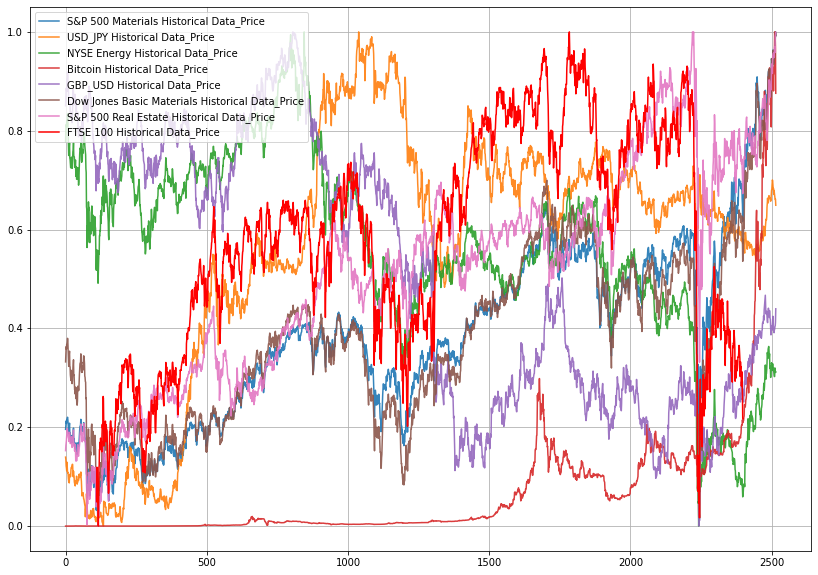

In [ ]:
K=110
N=2400
plt.figure(figsize=(14,10))
plt.grid('on')
for bf in best_features_z.columns:
  plt.plot(dfn[bf], label=bf, alpha=0.9)
plt.plot(dfn[KEY][K:N], label=KEY, color = 'red')
#plt.plot(dfn['LIBOR USD_1M'][K:N], label='LIBOR USD_ON')
plt.legend()
plt.show()

In [ ]:
#cols = ['Date', KEY] + list(best_features_z.columns) +['d1', 'd2', 'd3']#list(best_features_n.columns)
cols = ['Date', KEY]   + ['sentiment score',	'bull score',	'bear score']  #list(best_features_n.columns)  ['sentiment score',	'bull score',	'bear score'] 
cols

['Date',
 'FTSE 100 Historical Data_Price',
 'sentiment score',
 'bull score',
 'bear score']

In [ ]:
data = df[cols]
mask = (data['Date'] <='2021-01-07') 
data = data.loc[mask]
data.info()
data  = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2447 entries, 0 to 2446
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            2447 non-null   datetime64[ns]
 1   FTSE 100 Historical Data_Price  2447 non-null   float64       
 2   sentiment score                 2447 non-null   float64       
 3   bull score                      2447 non-null   float64       
 4   bear score                      2447 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 114.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2447 entries, 0 to 2446
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            2447 non-null   datetime64[ns]
 1   FTSE 100 Historical Data_Price  2447 non-n

In [ ]:
_std =data[KEY].std()
_mean = data[KEY].mean()
_min = data[KEY].min()
_max = data[KEY].max()
_mean, _std, _max, _min

(6612.6133837351845, 656.9011736975793, 7877.45, 4944.44)

In [ ]:
zn_train_df = z_df(data, 1, [KEY, 'Date'])#, no_cols=['d1', 'd2'])
zn_train_df.info()
z_y_key = 'z_'+KEY
z_y_key

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2447 entries, 0 to 2446
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              2447 non-null   datetime64[ns]
 1   FTSE 100 Historical Data_Price    2447 non-null   float64       
 2   sentiment score                   2447 non-null   float64       
 3   bull score                        2447 non-null   float64       
 4   bear score                        2447 non-null   float64       
 5   z_FTSE 100 Historical Data_Price  2447 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 133.8 KB


'z_FTSE 100 Historical Data_Price'

In [ ]:
# f_cols = ['price','sentiment score','bull score', 'bear score']
#ifft_cols = list(best_features_z.columns) +['d1', 'd2', 'd3']#[]#['sentiment score','bull score', 'bear score']+ ['d1', 'd2'] 
ifft_cols =  [z_y_key, 'sentiment score',	'bull score',	'bear score'] # ['sentiment score','bull score', 'bear score'] 
list_fft_comp = [16, 64]
key_for_d =  z_y_key + '_' + str(max(list_fft_comp)) + '_ifft'
key_for_d

'z_FTSE 100 Historical Data_Price_64_ifft'

In [ ]:
for key_ in ifft_cols:  
   zn_train_df = ifft_add_columns(zn_train_df, key_, list_fft_comp, n_adds =1000)
zn_train_df = zn_train_df.drop(columns=ifft_cols)
zn_train_df.info()

(2447, 7)
(2447, 8)
(2447, 9)
(2447, 10)
(2447, 11)
(2447, 12)
(2447, 13)
(2447, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2447 entries, 0 to 2446
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      2447 non-null   datetime64[ns]
 1   FTSE 100 Historical Data_Price            2447 non-null   float64       
 2   z_FTSE 100 Historical Data_Price_16_ifft  2447 non-null   float64       
 3   z_FTSE 100 Historical Data_Price_64_ifft  2447 non-null   float64       
 4   sentiment score_16_ifft                   2447 non-null   float64       
 5   sentiment score_64_ifft                   2447 non-null   float64       
 6   bull score_16_ifft                        2447 non-null   float64       
 7   bull score_64_ifft                        2447 non-null   float64       
 8   bear score_16_ifft     

In [ ]:
zn_train_df['d1'] = (shift_from_end(zn_train_df[key_for_d],1)-zn_train_df[key_for_d])
zn_train_df['d2'] =(shift_from_end(zn_train_df['d1'],1)-zn_train_df['d1'])
#zn_train_df['d3'] =(shift_from_end(zn_train_df['d2'],1)-zn_train_df['d2'])
zn_train_df = z_df(zn_train_df, cols=['d1', 'd2'])#, 'd3'])

In [ ]:
for key_ in ['d1', 'd2']:  
   zn_train_df = ifft_add_columns(zn_train_df, key_, list_fft_comp, n_adds =1000)
zn_train_df = zn_train_df.drop(columns=['d1', 'd2'])

(2447, 13)
(2447, 14)
(2447, 15)
(2447, 16)


In [ ]:
#zn_train_df = z_df(zn_train_df, 1, [KEY, 'Date'])#, no_cols=['d1', 'd2'])
zn_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2447 entries, 0 to 2446
Data columns (total 14 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      2447 non-null   datetime64[ns]
 1   FTSE 100 Historical Data_Price            2447 non-null   float64       
 2   z_FTSE 100 Historical Data_Price_16_ifft  2447 non-null   float64       
 3   z_FTSE 100 Historical Data_Price_64_ifft  2447 non-null   float64       
 4   sentiment score_16_ifft                   2447 non-null   float64       
 5   sentiment score_64_ifft                   2447 non-null   float64       
 6   bull score_16_ifft                        2447 non-null   float64       
 7   bull score_64_ifft                        2447 non-null   float64       
 8   bear score_16_ifft                        2447 non-null   float64       
 9   bear score_64_ifft            

In [ ]:
zn_train_df['y'] = (zn_train_df[KEY]-_mean)/_std
#zn_train_df = zn_train_df.drop(columns=[z_y_key])

In [ ]:
zn_train_df

,Date,FTSE 100 Historical Data_Price,z_FTSE 100 Historical Data_Price_16_ifft,z_FTSE 100 Historical Data_Price_64_ifft,sentiment score_16_ifft,sentiment score_64_ifft,bull score_16_ifft,bull score_64_ifft,bear score_16_ifft,bear score_64_ifft,d1_16_ifft,d1_64_ifft,d2_16_ifft,d2_64_ifft,y
0,2011-04-19,5896.87,1.248958,1.048738,0.192143,0.274970,0.129903,0.361571,0.386626,0.257587,0.390900,0.153430,0.003419,0.055008,-1.089575
1,2011-04-20,6022.26,1.253446,1.050122,0.191712,0.275719,0.120938,0.340802,0.390107,0.251574,0.391304,0.145140,0.003661,0.057538,-0.898694
2,2011-04-21,6018.30,1.257940,1.051475,0.191369,0.277074,0.111965,0.319148,0.393585,0.244857,0.391630,0.136326,0.003910,0.059898,-0.904723
3,2011-04-25,6043.83,1.262441,1.052781,0.191115,0.279035,0.102990,0.296628,0.397058,0.237437,0.391878,0.127127,0.004164,0.062024,-0.865858
4,2011-04-26,6069.36,1.266946,1.054023,0.190952,0.281598,0.094022,0.273265,0.400525,0.229318,0.392048,0.117719,0.004423,0.063858,-0.826994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,2020-12-31,6460.52,0.784720,0.334018,0.249241,0.367556,0.464250,0.649329,0.214774,0.270099,0.136828,0.078756,0.005139,0.292508,-0.231532
2443,2021-01-04,6571.88,0.783613,0.359573,0.241754,0.339157,0.467656,0.662068,0.215641,0.275602,0.136363,0.075490,0.005013,0.288754,-0.062008
2444,2021-01-05,6612.25,0.782584,0.386771,0.234238,0.310168,0.471048,0.674116,0.216526,0.280959,0.135869,0.122020,0.004885,0.283497,-0.000553
2445,2021-01-06,6841.86,0.781632,0.415476,0.226694,0.280662,0.474425,0.685431,0.217428,0.286154,0.135345,0.182552,0.004755,0.276751,0.348982


In [ ]:
zn_train_df.info(max_cols=600)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2447 entries, 0 to 2446
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      2447 non-null   datetime64[ns]
 1   FTSE 100 Historical Data_Price            2447 non-null   float64       
 2   z_FTSE 100 Historical Data_Price_16_ifft  2447 non-null   float64       
 3   z_FTSE 100 Historical Data_Price_64_ifft  2447 non-null   float64       
 4   sentiment score_16_ifft                   2447 non-null   float64       
 5   sentiment score_64_ifft                   2447 non-null   float64       
 6   bull score_16_ifft                        2447 non-null   float64       
 7   bull score_64_ifft                        2447 non-null   float64       
 8   bear score_16_ifft                        2447 non-null   float64       
 9   bear score_64_ifft            

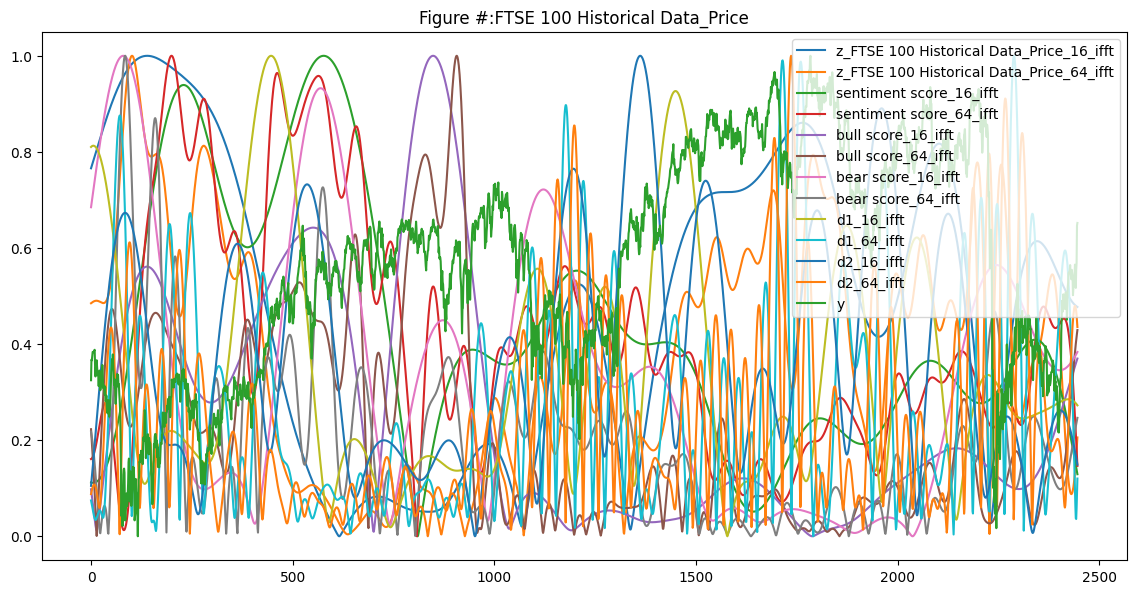

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
for_gr = norm_df(zn_train_df, no_cols=['Date'])
ifft_res = {}
for key_ in for_gr.columns[2:]:
    plt.plot(for_gr[key_], label=key_)
plt.title('Figure #:' + KEY)
plt.legend()
plt.show()

In [ ]:
window = 64
f = 32

In [ ]:
# x = []
# y = []
# i = 0
# while window + i + f + 1  < zn_train_df.shape[0]:
#     df_x = zn_train_df.iloc[i:window+i, 2:zn_train_df.shape[1]].reset_index(drop = 1)# - ntrain_df.iloc[i:window +i, 2:].reset_index(drop = 1)
#     x.append(df_x.to_numpy())
#     df_y = zn_train_df.iloc[window+i+1:window+i+f+1, zn_train_df.shape[1]-1].reset_index(drop = 1)
#     y.append(df_y.to_numpy())
#     i += 1
# x = np.array(x)
# x.shape

In [ ]:
x = []
y = []
i = 0
while window + i + 1  < zn_train_df.shape[0]:
    df_x = zn_train_df.iloc[i:window+i, 2:zn_train_df.shape[1]].reset_index(drop = 1)# - ntrain_df.iloc[i:window +i, 2:].reset_index(drop = 1)
    x.append(df_x.to_numpy())
    df_y = ((df.iloc[window+i+1:window+i+f+1, list(df.columns).index(KEY)].reset_index(drop = 1))-_mean)/_std
    y.append(df_y.to_numpy())
    #print(df_y.to_numpy().shape)
    i += 1
x = np.array(x)
y = np.array(y)
x.shape, y.shape

((2382, 64, 13), (2382, 32))

In [ ]:
#i = 31
#str(list(dfn['GS_High'][i+1:window+i+1]*(_max-_min)+_min))
#x[31,:,0]*(_max-_min)+_min

In [ ]:
x_c = np.reshape(x, (-1, x.shape[1], x.shape[2], 1))
x_l = np.reshape(x, (-1, x.shape[1], x.shape[2]))
x_c.shape, x_l.shape

((2382, 64, 13, 1), (2382, 64, 13))

In [ ]:
y = np.array(y)
y.shape


(2382, 32)

In [ ]:
y_c = np.reshape(y, (-1, f, 1))
y_l = np.reshape(y, (-1, f))
y_c.shape, y_l.shape, y.shape

((2382, 32, 1), (2382, 32), (2382, 32))

In [ ]:
str(list(data[KEY][window+1:window+f+1]))

'[5935.02, 5925.26, 5929.73, 5856.58, 5873.21, 5815.19, 5774.43, 5718.39, 5584.51, 5393.14, 5068.95, 5077.5, 5164.92, 5007.16, 5168.24, 5320.03, 5350.58, 5357.63, 5331.6, 5092.23, 5040.76, 5095.3, 5129.42, 5205.85, 5131.1, 5129.92, 5199.29, 5268.66, 5394.53, 5418.65, 5292.03, 5156.84]'

In [ ]:
pred_test = y[0] * _std + _mean
pred_test

array([5935.02, 5925.26, 5929.73, 5856.58, 5873.21, 5815.19, 5774.43,
       5718.39, 5584.51, 5393.14, 5068.95, 5077.5 , 5164.92, 5007.16,
       5168.24, 5320.03, 5350.58, 5357.63, 5331.6 , 5092.23, 5040.76,
       5095.3 , 5129.42, 5205.85, 5131.1 , 5129.92, 5199.29, 5268.66,
       5394.53, 5418.65, 5292.03, 5156.84])

In [ ]:
# pred_test = y[0:1] * (_max - _min) + _min
# pred_test

In [ ]:
#pred2[0:1,0:1].flatten() *(_max - _min) + _min

## Пробуем LSTM

In [ ]:
N = 2380 # разбиваем на train и val 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.models import Sequential, Model

In [ ]:
lstm = Sequential(name="LSTM")
lstm.add(LSTM(1024, recurrent_regularizer='L2' , input_shape = (x.shape[1], x.shape[2]), return_sequences="True"))
lstm.add(LSTM(1024, recurrent_regularizer='L2')) #, return_sequences="True"))
#model.add(Conv1D(64, 3, activation="linear"))
# model.add(Conv1D(64, 3, activation="linear"))
# model.add(Flatten())
# model.add(Dense(16, activation="linear"))
lstm.add(Dense(y.shape[1], activation="linear"))

lstm.compile(loss="mae", optimizer="adam", metrics=['mae'])
lstm.summary()


Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64, 1024)          4251648   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
dense (Dense)                (None, 32)                32800     
Total params: 12,677,152
Trainable params: 12,677,152
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm.load_weights(W_PATH + 'lstm_FTSE_070121_1000_3_1024_1024_y_ifft16-64(snt+y+d1+d2)_16-32_0.0960841178894043')

In [ ]:
callback = EarlyStopping(monitor='val_mae', mode = 'min',  patience=15,  restore_best_weights=1, verbose = 1)  # patience=100
history = lstm.fit(
    x_l[:N], y_l[:N],
    epochs=200,
    validation_data=(x_l[N:], y_l[N:]),
    callbacks=[callback])

Epoch 1/200
75/75 [==============================] - 39s 70ms/step - loss: 0.0960 - mae: 0.0895 - val_loss: 0.1109 - val_mae: 0.1044
Epoch 2/200
75/75 [==============================] - 5s 61ms/step - loss: 0.0940 - mae: 0.0879 - val_loss: 0.1609 - val_mae: 0.1547
Epoch 3/200
75/75 [==============================] - 5s 61ms/step - loss: 0.0954 - mae: 0.0890 - val_loss: 0.1226 - val_mae: 0.1150
Epoch 4/200
75/75 [==============================] - 5s 61ms/step - loss: 0.0952 - mae: 0.0882 - val_loss: 0.1271 - val_mae: 0.1219
Epoch 5/200
75/75 [==============================] - 5s 61ms/step - loss: 0.0930 - mae: 0.0872 - val_loss: 0.1014 - val_mae: 0.0965
Epoch 6/200
75/75 [==============================] - 5s 62ms/step - loss: 0.0917 - mae: 0.0861 - val_loss: 0.1113 - val_mae: 0.1059
Epoch 7/200
75/75 [==============================] - 5s 62ms/step - loss: 0.0912 - mae: 0.0858 - val_loss: 0.1094 - val_mae: 0.1046
Epoch 8/200
75/75 [==============================] - 5s 62ms/step - loss: 0

In [ ]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
evaluate_lstm = lstm.evaluate(x_l[N:], y_l[N:])

1/1 [==============================] - 0s 28ms/step - loss: 0.0801 - mae: 0.0754


In [64]:
lstm.save_weights(W_PATH + 'lstm_FTSE2_070121_1000_3_1024_1024_y_ifft16-64(snt+y+d1+d2)_16-32_'+str(evaluate_lstm[1]))

# Пробуем discriminator

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(x.shape[1], x.shape[2], 1)),
        layers.Conv2D(512, (9, 9), strides=(1, 1), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, (7, 7), strides=(1, 1), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, (3, 3), strides=(1, 1), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(y.shape[1], (3, 3), strides=(1, 1), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 13, 512)       41984     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 13, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 13, 256)       6422784   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 13, 256)       590080    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 13, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 13, 32)      

In [ ]:
discriminator.compile(loss="mae", optimizer="adam", metrics=['mae'])

In [ ]:
discriminator.load_weights(W_PATH + 'disc_FTSE_070121_1000_3_1024_1024_y_ifft16-64(snt+y+d1+d2)_16-32_0.09056209772825241')

In [ ]:
callback = EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=1, verbose = 1)
history = discriminator.fit(x_c[:N], y_c[:N], epochs=200, batch_size=32, validation_data=(x_c[N:], y_c[N:]), callbacks=[callback])

Epoch 1/200
75/75 [==============================] - 16s 164ms/step - loss: 0.0906 - mae: 0.0906 - val_loss: 0.1033 - val_mae: 0.1033
Epoch 2/200
75/75 [==============================] - 11s 146ms/step - loss: 0.0977 - mae: 0.0977 - val_loss: 0.1004 - val_mae: 0.1004
Epoch 3/200
75/75 [==============================] - 11s 148ms/step - loss: 0.0947 - mae: 0.0947 - val_loss: 0.1002 - val_mae: 0.1002
Epoch 4/200
75/75 [==============================] - 11s 145ms/step - loss: 0.0979 - mae: 0.0979 - val_loss: 0.0941 - val_mae: 0.0941
Epoch 5/200
75/75 [==============================] - 11s 144ms/step - loss: 0.0981 - mae: 0.0981 - val_loss: 0.1038 - val_mae: 0.1038
Epoch 6/200
75/75 [==============================] - 11s 143ms/step - loss: 0.0986 - mae: 0.0986 - val_loss: 0.1104 - val_mae: 0.1104
Epoch 7/200
75/75 [==============================] - 11s 143ms/step - loss: 0.0978 - mae: 0.0978 - val_loss: 0.1241 - val_mae: 0.1241
Epoch 8/200
75/75 [==============================] - 11s 143ms

KeyboardInterrupt: ignored

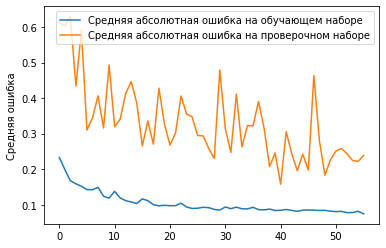

In [ ]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [62]:
evaluate_d = discriminator.evaluate(x_c[N:], y_c[N:])

1/1 [==============================] - 0s 30ms/step - loss: 0.1015 - mae: 0.1015


In [63]:
discriminator.save_weights(W_PATH + 'disc_FTSE2_070121_1000_3_1024_1024_y_ifft16-64(snt+y+d1+d2)_16-32_'+str(evaluate_d[1]))

In [65]:
def add_shift(xs, n):
    xs = xs.flatten()
    e = np.empty(n)
    e[:n] = np.nan 
    if n >= 0:
        e = np.append(e, xs, axis = 0)
    return e

In [66]:
# Напоминалка
x_c.shape, data.shape, window, f, np.array(df[KEY]).shape, np.array(df[KEY]).shape[0] - window

((2382, 64, 13, 1), (2447, 5), 64, 32, (2516,), 2452)

In [67]:
N = 2250  # старт отображения в масштабе x (сдвиг на window)
K = zn_train_df.shape[0]
pred = discriminator.predict(x_c[N:K])* _std + _mean #* (_max - _min) + _min
pred2 = lstm.predict(x_l[N:K])* _std + _mean
y_plot = y[N:K, 0:1].flatten()* _std + _mean
print(pred.min(),  pred.max(), pred2.min(), pred2.max(), y_plot.min(), y_plot.max())
print(add_shift(pred[:,0:1],1).min(),  add_shift(pred[:,0:1],1).max(), add_shift(pred2[:,0:1],1).min(), add_shift(pred2[:,0:1],1).max(), y_plot.min(), y_plot.max())
pred.shape, pred2.shape, y_plot.shape
Y = np.array(df[KEY][window + N +1:])#window + K:])# + 2:])#window + K + 2])

5676.0737 6933.1143 5687.262 6881.478 5577.27 6856.96
nan nan nan nan 5577.27 6856.96


#пока не нужно

In [ ]:
# # вычислим батч по данным из "окна" f
# xp = []
# start = zn_train_df.shape[0]-f-window-1
# print(start)
# i = 0
# while start + window + i   < zn_train_df.shape[0]:
#     df_x = zn_train_df.iloc[start + i:start + window+i, 2:zn_train_df.shape[1]].reset_index(drop = 1)# - ntrain_df.iloc[i:window +i, 2:].reset_index(drop = 1)
#     xp.append(df_x.to_numpy())
#     # df_y = zn_train_df.iloc[window+i:window+i+f, zn_train_df.shape[1]-1].reset_index(drop = 1)
#     # y.append(df_y.to_numpy())
#     i += 1
# xp = np.array(xp)
# print(xp.shape)
# xp_c = np.reshape(xp, (-1, xp.shape[1], xp.shape[2], 1))
# xp_l = np.reshape(xp, (-1, xp.shape[1], xp.shape[2]))
# pred_yf_cov =  discriminator.predict(xp_c)* _std + _mean #* (_max - _min) + _min
# pred2_yf = lstm.predict(xp_l)* _std + _mean

In [ ]:
# str(list(pred2[:,31:32].flatten()))

In [ ]:
# str(list(pred2[:,0:1].flatten()))

In [ ]:
# pred_yf_cov[:,31:32].flatten()

# График по итогам обучения

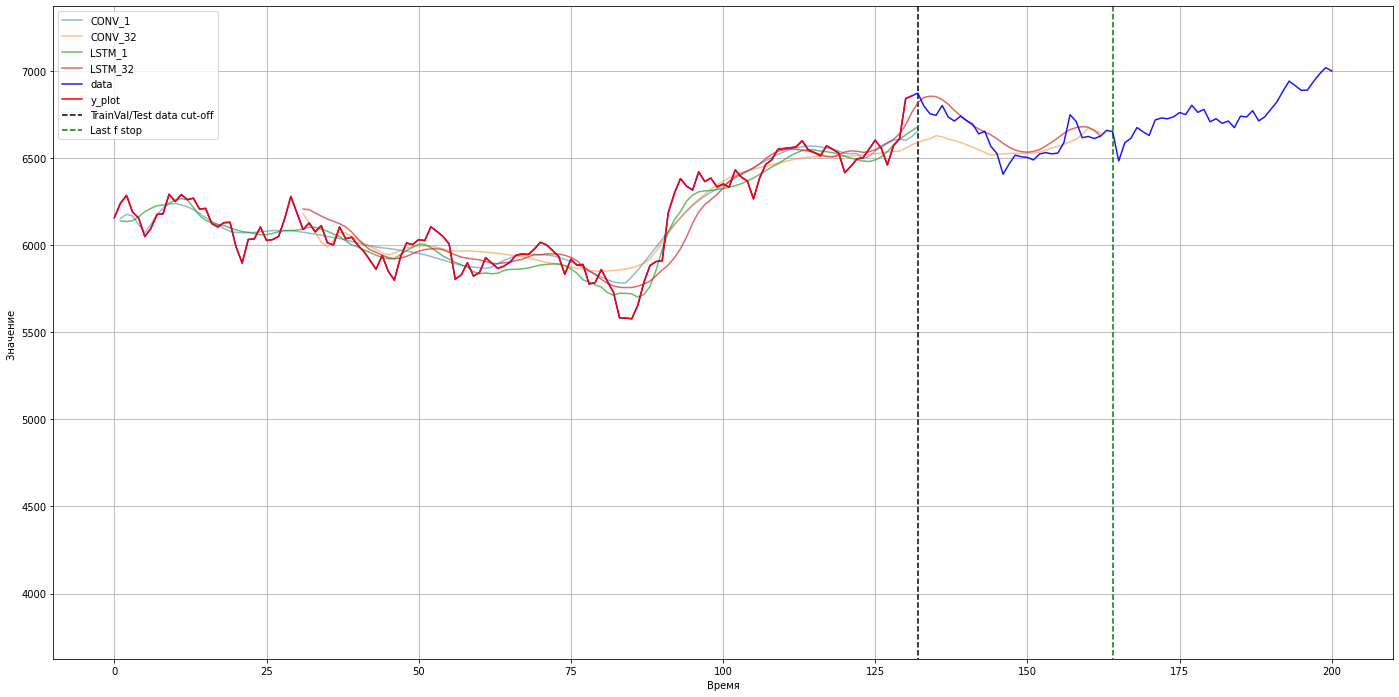

In [68]:
plt.figure(figsize=(24,12))
plt.grid('on')

plt.plot(add_shift(pred[:,0:1],1), label='CONV_1', alpha = 0.5)
# plt.plot(add_shift(pred[:,1:2],2), label='CONV_2', alpha = 0.5)
# plt.plot(add_shift(pred[:,2:3],3), label='CONV_3', alpha = 0.5)
plt.plot(add_shift(pred[:,31:32],31), label='CONV_32', alpha = 0.5)

plt.plot(add_shift(pred2[:,0:1],1), label='LSTM_1', alpha = 0.7)
# plt.plot(add_shift(pred2[:,1:2],2), label='LSTM_2', alpha = 0.7)
# plt.plot(add_shift(pred2[:,2:3],3), label='LSTM_3', alpha = 0.7)
plt.plot(add_shift(pred2[:,31:32],31), label='LSTM_32', alpha = 0.7)

plt.plot(Y, label='data', alpha =0.9, color = 'blue')
plt.plot(y_plot, label='y_plot', alpha =1, color = 'red')

# plt.plot(add_shift(pred_yf_cov[:,0:1],  x_c.shape[0]-N), label='CONV_1_xf', alpha = 0.5)
# plt.plot(add_shift(pred_yf_cov[:,31:32],  x_c.shape[0]-N+f), label='CONV_32_xf', alpha = 0.5)

# plt.plot(add_shift(pred2_yf[:,0:1], x_l.shape[0]-N), label='lstm_1_xf', alpha = 0.5)
# plt.plot(add_shift(pred2_yf[:,31:32], x_l.shape[0]-N+f), label='lstm_32_xf', alpha = 0.5)

plt.vlines(zn_train_df.shape[0]-N-1-window, 1.05*Y.max(), 0, linestyles='--', label='TrainVal/Test data cut-off', color = 'black')
plt.vlines(zn_train_df.shape[0]-N-1-window +f , 1.05*Y.max(), 0, linestyles='--', label='Last f stop', color = 'green')

plt.xlabel('Время')
plt.ylabel('Значение ')

plt.ylim([0.65*Y.min(), 1.05*Y.max()])

plt.legend()
plt.show()

# График предсказания

In [ ]:
N = 2250  # старт отображения в масштабе x (сдвиг на window)
K = zn_train_df.shape[0]
pred = discriminator.predict(x_c[N:K])* _std + _mean #* (_max - _min) + _min
pred2 = lstm.predict(x_l[N:K])* _std + _mean
pred.shape, pred2.shape
Y = np.array(df[KEY][window + N +1:])#window + K:])# + 2:])#window + K + 2])

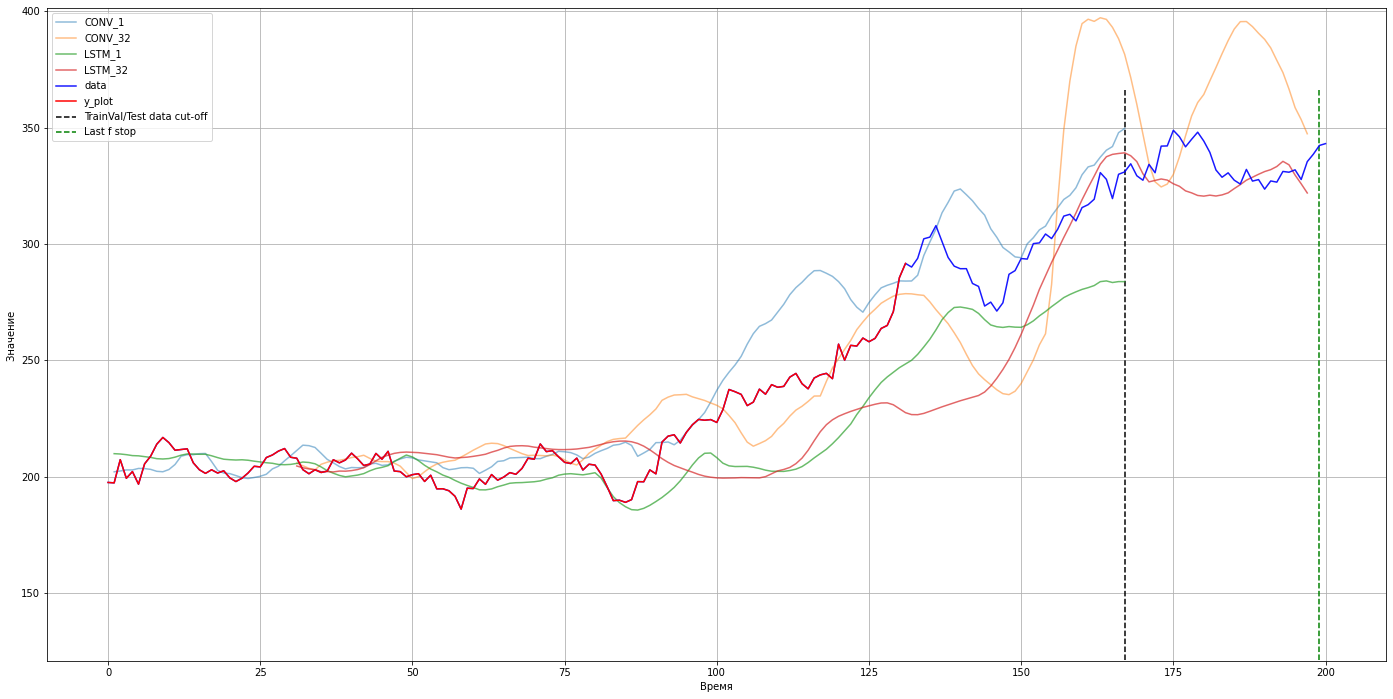

In [ ]:
plt.figure(figsize=(24,12))
plt.grid('on')

plt.plot(add_shift(pred[:,0:1],1), label='CONV_1', alpha = 0.5)
# plt.plot(add_shift(pred[:,1:2],2), label='CONV_2', alpha = 0.5)
# plt.plot(add_shift(pred[:,2:3],3), label='CONV_3', alpha = 0.5)
plt.plot(add_shift(pred[:,31:32],31), label='CONV_32', alpha = 0.5)

plt.plot(add_shift(pred2[:,0:1],1), label='LSTM_1', alpha = 0.7)
# plt.plot(add_shift(pred2[:,1:2],2), label='LSTM_2', alpha = 0.7)
# plt.plot(add_shift(pred2[:,2:3],3), label='LSTM_3', alpha = 0.7)
plt.plot(add_shift(pred2[:,31:32],31), label='LSTM_32', alpha = 0.7)

plt.plot(Y, label='data', alpha =0.9, color = 'blue')
plt.plot(y_plot, label='y_plot', alpha =1, color = 'red')

# plt.plot(add_shift(pred_yf_cov[:,0:1],  x_c.shape[0]-N), label='CONV_1_xf', alpha = 0.5)
# plt.plot(add_shift(pred_yf_cov[:,31:32],  x_c.shape[0]-N+f), label='CONV_32_xf', alpha = 0.5)

# plt.plot(add_shift(pred2_yf[:,0:1], x_l.shape[0]-N), label='lstm_1_xf', alpha = 0.5)
# plt.plot(add_shift(pred2_yf[:,31:32], x_l.shape[0]-N+f), label='lstm_32_xf', alpha = 0.5)

plt.vlines(zn_train_df.shape[0]-N-1-window, 1.05*Y.max(), 0, linestyles='--', label='TrainVal/Test data cut-off', color = 'black')
plt.vlines(zn_train_df.shape[0]-N-1-window +f , 1.05*Y.max(), 0, linestyles='--', label='Last f stop', color = 'green')

plt.xlabel('Время')
plt.ylabel('Значение ')

plt.ylim([0.65*Y.min(), 1.15*Y.max()])

plt.legend()
plt.show()

#STOP здесь   STOP здесь        STOP здесь STOP здесь     STOP здесь     STOP здесь 

In [ ]:
# dataset_train = keras.preprocessing.timeseries_dataset_from_array(
#     x[:N],
#     y[:N],
#     sequence_length=pastLen,
#     sampling_rate=1,
#     batch_size=batch_size,
# )
# dataset_val = keras.preprocessing.timeseries_dataset_from_array(
#     x[N:],
#     y[N:],
#     sequence_length=pastLen,
#     sampling_rate=1,
#     batch_size=batch_size,
# )

In [ ]:
# discriminator = keras.Sequential(
#     [
#         keras.Input(shape=(x.shape[1], x.shape[2], 1)),
#         layers.Conv2D(24, (9, 9), strides=(1, 1), padding="same", activation='tanh'),
#         #layers.LeakyReLU(alpha=0.5),
#         layers.Conv2D(32, (7, 7), strides=(1, 1), padding="same",  activation='tanh'),
#         #layers.LeakyReLU(alpha=0.5),
#         layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation='tanh'),
#         #layers.LeakyReLU(alpha=0.5),
#         layers.Conv2D(3, (3, 3), strides=(1, 1), padding="same", activation='tanh'),
#         #layers.LeakyReLU(alpha=0.5),
#         layers.GlobalMaxPooling2D(),
#     ],
#     name="discriminator",
# )

# discriminator.summary()

In [ ]:
# def shift(xs, n):
#     e = np.empty_like(xs)
#     if n >= 0:
#         e[:n] = np.nan
#         e[n:] = xs[:-n]
#     else:
#         e[n:] = np.nan
#         e[:n] = xs[-n:]
#     return e

In [ ]:
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 7x7x24 map
        layers.Dense(7 * 7 * latent_dim),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, latent_dim)),
        layers.Conv2DTranspose(24, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(12, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
        layers.Dense(7),
        
    ],
    name="generator",
)

generator.summary()

## Класс со своим этапом обучения `train_step`

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, batch):

        latent_vectors = self.discriminator(batch)
        generated_images = self.generator(latent_vectors)

        with tf.GradientTape() as tape:
            predictions = self.generator(self.discriminator(batch))
            d_loss = self.loss_fn(batch, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        with tf.GradientTape() as tape:
            predictions = self.generator(latent_vectors)
            g_loss = self.loss_fn(batch, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
      
        return {"d_loss": d_loss, "g_loss": g_loss}

    def predict(self,x):
        latent_vectors = self.discriminator(x)
        generated_images = self.generator(latent_vectors)
        return generated_images


In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        #latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # print(all_digits[0:3].shape)
        # latent_vectors = self.model.discriminator(tf.convert_to_tensor(all_digits[0:3], dtype=tf.int64))
        #generated_images = self.model.generator(latent_vectors)
        generated_images = self.model.predict(all_digits[0:3])
        generated_images *=255
        generated_images.numpy()
        plt.imshow(np.reshape(generated_images[2], (28, 28)), cmap=pyplot.get_cmap('gray'))
        plt.show()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

## Учим end-to-end модель

In [ ]:
epochs = 1
steps = 12
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.003),
    loss_fn=keras.losses.MeanSquaredError(),
)
n = 0
for s in range(steps):
    gan.fit(
      dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)])
    generated_images = gan.predict(all_digits[n:3+n])
    generated_images *=255
    generated_images.numpy()
    plt.figure(figsize=(5,5))
    k = 0
    w = 0
    for i in range(1,4):
        for j in range(1,3):
          if j == 1:
            plt.subplot(3,2,k+1)
            plt.imshow(x_train[n+w], cmap=pyplot.get_cmap('gray'))
          else:
            plt.subplot(3,2,k+2)
            plt.imshow(np.reshape(generated_images[w], (28, 28)), cmap=pyplot.get_cmap('gray'))
        k +=2
        w+=1  


In [ ]:
# epochs = 15

# gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
# gan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=0.003),
#     g_optimizer=keras.optimizers.Adam(learning_rate=0.003),
#     loss_fn=keras.losses.MeanSquaredError(),
# )

# gan.fit(
#     dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
# )

In [ ]:
aaa =all_digits[0:100]

In [ ]:
p = gan.predict(aaa)

In [ ]:
n=0
plt.figure(figsize=(18,18))
k = 0
w = 0
for i in range(1,10):
    for j in range(1,3):
      if j == 1:
        plt.subplot(9,2,k+1)#i*4+j+1)
        plt.imshow(x_train[n+w], cmap=pyplot.get_cmap('gray'))
      else:
        plt.subplot(9,2,k+2)#i*4+j+1)
        plt.imshow(np.reshape(p[n+w], (28, 28))*255, cmap=pyplot.get_cmap('gray'))
       # y_t = np.argmax(y_train10[n+k], axis = 1)
    k +=2
    w+=1
plt.show()

In [ ]:
for i in range(9):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(np.reshape(p[i], (28, 28))*255-x_train[i], cmap=pyplot.get_cmap('gray'))
  #pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

Display the last generated images:

In [ ]:
from IPython.display import Image, display

display(Image("generated_img_0_2.png"))
display(Image("generated_img_1_2.png"))
display(Image("generated_img_2_2.png"))

In [ ]:
display(Image("generated_img_0_0.png"))
display(Image("generated_img_0_1.png"))
display(Image("generated_img_0_2.png"))

In [ ]:
# epochs = 1
# steps = 12
# gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
# gan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=0.003),
#     g_optimizer=keras.optimizers.Adam(learning_rate=0.003),
#     loss_fn=keras.losses.MeanSquaredError(),
# )
# for s in range(steps):
#     gan.fit(
#       dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)])
#     generated_images = gan.predict(all_digits[0:3])
#     generated_images *=255
#     generated_images.numpy()
#     plt.imshow(np.reshape(generated_images[2], (28, 28)), cmap=pyplot.get_cmap('gray'))
#     plt.show()

In [ ]:
# MNIST 
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
# генератор батчей
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

In [ ]:
all_digits.shape


In [ ]:
from matplotlib import pyplot
for i in range(9):  
  pyplot.subplot(330 + 1 + i)
  print(x_train[i].shape)
  pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()